In [1]:
import torch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [168]:
from torchmetrics import Accuracy

In [196]:

from torchinfo import summary

In [155]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os

In [51]:
from PIL import Image
import random
import pathlib
import pandas as pd

random.seed(42)

In [32]:
def walk_directory(directory):
    for dirpath, dirnames, filenames in os.walk(directory):
        print(
            f"Found number of directory: {len(dirnames)} with {len(filenames)} files in {dirpath}"
        )

In [33]:
walk_directory("pizza_steak_sushi/train")

Found number of directory: 3 with 0 files in pizza_steak_sushi/train
Found number of directory: 0 with 78 files in pizza_steak_sushi/train\pizza
Found number of directory: 0 with 75 files in pizza_steak_sushi/train\steak
Found number of directory: 0 with 72 files in pizza_steak_sushi/train\sushi


In [34]:
walk_directory("pizza_steak_sushi/test")

Found number of directory: 3 with 0 files in pizza_steak_sushi/test
Found number of directory: 0 with 25 files in pizza_steak_sushi/test\pizza
Found number of directory: 0 with 19 files in pizza_steak_sushi/test\steak
Found number of directory: 0 with 31 files in pizza_steak_sushi/test\sushi


In [47]:
trainDir = pathlib.Path("pizza_steak_sushi/train")
testDir = pathlib.Path("pizza_steak_sushi/test")

trainDir, testDir

(WindowsPath('pizza_steak_sushi/train'), WindowsPath('pizza_steak_sushi/test'))

In [48]:
dataDir = pathlib.Path("pizza_steak_sushi")

In [54]:
Image_path_list = list(dataDir.glob("*/*/*.jpg"))

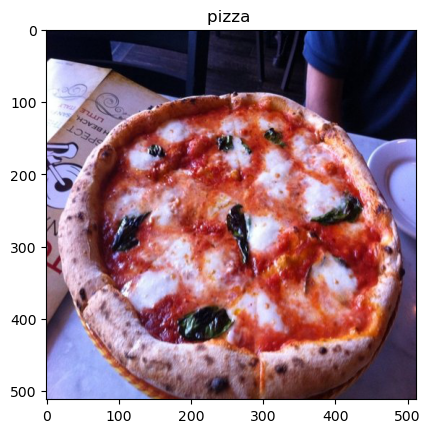

In [98]:
random_number = random.randint(0, len(Image_path_list))
plt.imshow(Image.open(Image_path_list[random_number]))
plt.title(f"{Image_path_list[random_number].parent.stem} ");

In [311]:
train_trasnform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
    ]
)

test_transform = transforms.Compose(    
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ]
)

In [105]:
Train_Images = list(trainDir.glob("*/*.jpg"))

In [110]:
X_TRAIN = []
y_TRAIN = []

X_test = []
y_test = []


In [111]:
for ele in Train_Images:
    label = ele.parent.stem
    image = Image.open(ele)
    image = data_transform(image)
    X_TRAIN.append(image)
    y_TRAIN.append(label)

In [112]:
print(f"Number of images in X_TRAIN: {len(X_TRAIN)}")
print(f"Number of labels in y_TRAIN: {len(y_TRAIN)}")


Number of images in X_TRAIN: 225
Number of labels in y_TRAIN: 225


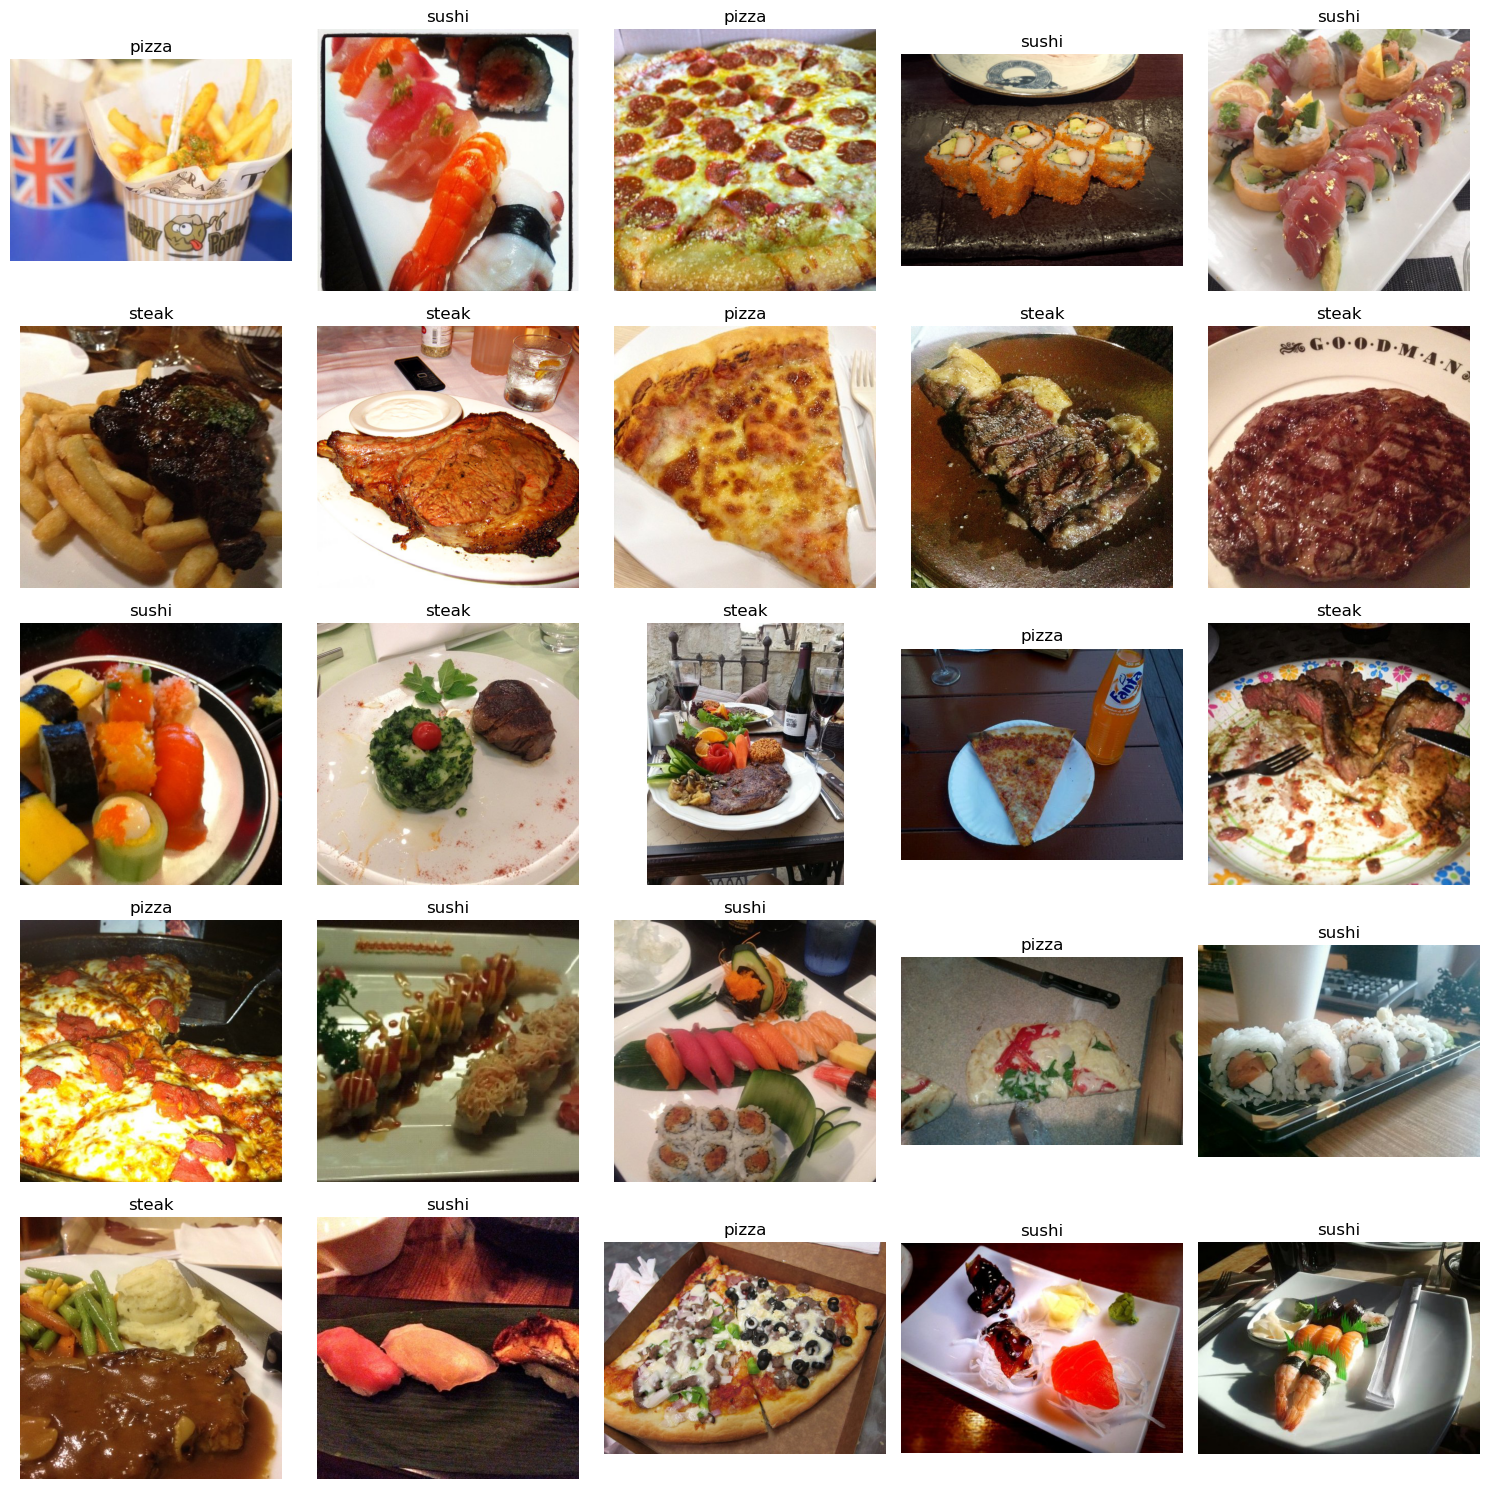

In [176]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))
axes = axes.flatten()

random_indices = random.sample(range(0, len(X_TRAIN)), 25)

for idx, ax in zip(random_indices, axes):
    image_path = Train_Images[idx]
    label = image_path.parent.stem
    image = Image.open(image_path)
    ax.imshow(image)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [312]:
train_data = datasets.ImageFolder(trainDir, transform=train_trasnform, target_transform=None)
test_data = datasets.ImageFolder(testDir, transform=test_transform, target_transform=None)  

In [313]:
class_names = train_data.classes
class_names = {k: v for k, v in enumerate(class_names)}
class_names

{0: 'pizza', 1: 'steak', 2: 'sushi'}

Text(0.5, 1.0, 'pizza')

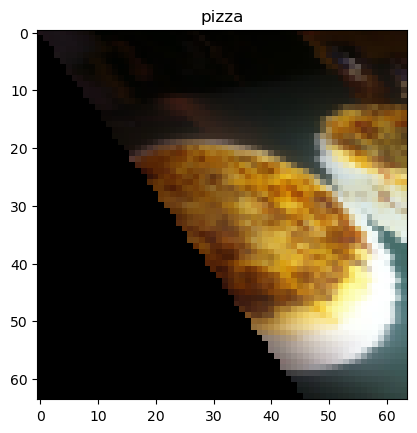

In [314]:
data , lab = train_data[0]
data.shape, lab

plt.imshow(data.permute(1, 2, 0))
plt.title(class_names[lab])

In [315]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)


In [316]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [317]:
one, b = iter(train_dataloader).__next__()
one.shape, b.shape  


(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [318]:
accuracy_function = Accuracy(task="multiclass", num_classes=3).to(device)

In [319]:
class ConvNet(nn.Module):
    def __init__(self, input_features, hidden_features, output_features) -> None:
        super().__init__()

        self.Conv_layer1 = nn.Sequential(
            nn.Conv2d(
                input_features, hidden_features, kernel_size=3, stride=1, padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                hidden_features, hidden_features, kernel_size=3, stride=1, padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.Conv_layer2 = nn.Sequential(
            nn.Conv2d(
                hidden_features, hidden_features, kernel_size=3, stride=1, padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                hidden_features, hidden_features, kernel_size=3, stride=1, padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.final = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_features * 16 * 16, output_features),
        )

    def forward(self, x):
        x = self.Conv_layer1(x)
        x = self.Conv_layer2(x)
        x = self.final(x)
        return x

In [320]:
model_0 = ConvNet(3, 10, 3).to(device)
model_0

ConvNet(
  (Conv_layer1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Conv_layer2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (final): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [321]:
summary(model=model_0, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [322]:
Loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [323]:
def accuracy_calculation(y_pred, y_true):
        correct = torch.eq(y_pred, y_true)
        accuracy = correct.sum().item() / len(correct)
        return accuracy * 100

In [329]:
EPOCHES = 5


TRAIN_ACC = []
TEST_ACC = []
TRAIN_LOSS = []
TEST_LOSS = []


In [330]:
for epoch in tqdm(range(EPOCHES)):

    train_loss_in = 0
    test_loss_in = 0
    train_acc_in = 0
    test_acc_in = 0

    print(
        f"-------------------------EPOCH {epoch}--------------------------------------------"
    )

    for ind, (X, y) in enumerate(train_dataloader):
        
        X = X.to(device)
        y = y.to(device)

        y_pred = model_0(X)

        loss = Loss_function(y_pred, y)

        train_loss_in += loss.item()
        y_pred = torch.argmax(y_pred, dim=1)  

        acc = accuracy_calculation(y_pred, y)

        train_acc_in += acc

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()


    train_loss_in /= len(train_dataloader)
    train_acc_in /= len(train_dataloader)
    print()

    for ind, (X, y) in enumerate(test_dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model_0(X)

        loss = Loss_function(y_pred, y)

        y_pred = torch.argmax(y_pred, dim=1)

        acc = accuracy_calculation(y_pred, y)

        test_acc_in += acc # Corrected from train_acc_in to test_acc_in

        test_loss_in += loss.item()

    test_loss_in /= len(test_dataloader)
    test_acc_in /= len(test_dataloader)

    TRAIN_ACC.append(train_acc_in)
    TEST_ACC.append(test_acc_in)
    TRAIN_LOSS.append(train_loss_in)
    TEST_LOSS.append(test_loss_in)

    if epoch % 1 == 0:
        print(
            f"Epoch: {epoch} Train Loss: {train_loss_in} Test Loss: {test_loss_in} Train Acc: {train_acc_in} Test Acc: {test_acc_in}"
        )
        print()
        
        print(
            "----------------------------------------------------------------------------"
        )
        print()


  0%|          | 0/5 [00:00<?, ?it/s]

-------------------------EPOCH 0--------------------------------------------

Epoch: 0 Train Loss: 1.0090072005987167 Test Loss: 1.1386581460634868 Train Acc: 53.90625 Test Acc: 34.28030303030303

----------------------------------------------------------------------------

-------------------------EPOCH 1--------------------------------------------

Epoch: 1 Train Loss: 1.0063598081469536 Test Loss: 1.1680567264556885 Train Acc: 54.6875 Test Acc: 29.166666666666668

----------------------------------------------------------------------------

-------------------------EPOCH 2--------------------------------------------

Epoch: 2 Train Loss: 1.006550446152687 Test Loss: 1.0730108221371968 Train Acc: 54.296875 Test Acc: 40.340909090909086

----------------------------------------------------------------------------

-------------------------EPOCH 3--------------------------------------------

Epoch: 3 Train Loss: 1.049706019461155 Test Loss: 1.0712626179059346 Train Acc: 47.265625 Test A

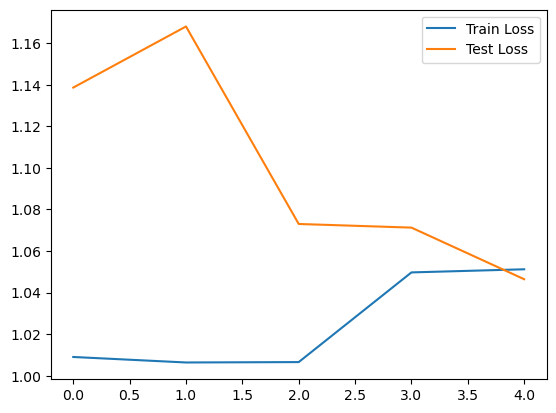

In [335]:

plt.plot(TRAIN_LOSS, label="Train Loss")
plt.plot(TEST_LOSS, label="Test Loss")
plt.legend()

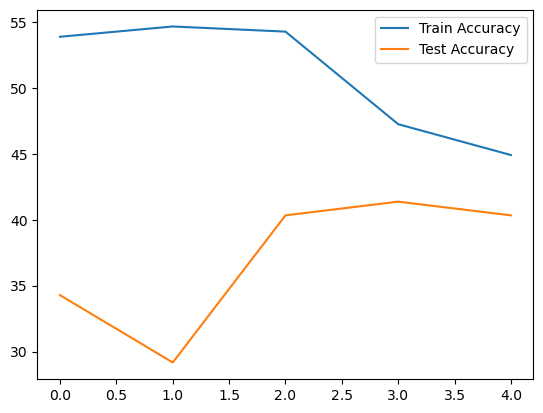

In [336]:
plt.plot(TRAIN_ACC, label="Train Accuracy")
plt.plot(TEST_ACC, label="Test Accuracy")
plt.legend()